# Fish Lake (FL) Elevation Bands 

### Notebook contents 
* Creating elevation bands, and some other visualiztion (box plots)
* Starting the anaylsis required for random forest analysis (mostly testing)

created by Cassie Lumbrazo\
date: July 2023\
python environment: **raster**


In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats

In [2]:
ds = xr.open_dataset('/home/lumbraca/raster/data/fl_model_cleandata_create_netcdf.nc')

In [3]:
# flatten everything to save time later
# canopy parameters
chm_snowoff_flat=ds.chm_snowoff.values.flatten()
chmws_flat=ds.chmws.values.flatten()
chmas_flat=ds.chmas.values.flatten()
dce_flat=ds.dce.values.flatten()
dce_reclass_flat=ds.dce_reclass.values.flatten()

# else 
slope_flat=ds.slope.values.flatten()
aspect_flat=ds.aspect.values.flatten()
dah_flat=ds.dah.values.flatten()
dah_reclass_flat=ds.dah_reclass.values.flatten()

snowdepth_flat=ds.snowdepth.values.flatten()
dem_flat=ds.dem.values.flatten()
tpi_flat=ds.tpi.values.flatten()

# I did not make these in the netcdf script 
# dce_dahpos_reclass_flat=ds.dce_dahpos_reclass.values.flatten()
# dce_dahneg_reclass_flat=ds.dce_dahneg_reclass.values.flatten()

# Sample Dataset First 

### Import all the sklearn things

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
import pydotplus 
from IPython.display import Image
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

#### We want to use a random forest generator to determine what best predictors for snow depth 
* ds.dem
* ds.dah
* ds.dce
* ds.tpi

In [5]:
# with regular dah and dce
ds_snowdepth = ds.snowdepth.values.flatten()
ds_dem = ds.dem.values.flatten()
ds_dah = ds.dah.values.flatten() # when we convert to an int, we are making all DAH 0? need to fix this for random forest 

ds_tpi = ds.tpi.values.flatten() 

ds_dah = ds_dah * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis
ds_dah = ds_tpi * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis

ds_dce = ds.dce.values.flatten()

# # with reclass dah and dce 
# ds_snowdepth = ds.snowdepth.values.flatten()
# ds_dem = ds.dem.values.flatten() 
# ds_dah = ds.dah_reclass.values.flatten()
# ds_dce = ds.dce_reclass.values.flatten()

If you want to subsample those variables, then run this gridcell below

In [6]:
# and if you want to subsample those values, then run this cell

num = 20 # number to sample (step) at... every other.. every 5, 10 etc.

ds_snowdepth = ds_snowdepth[::num] #start:stop:step
ds_dem = ds_dem[::num] 
ds_dce = ds_dce[::num] 
ds_dah = ds_dah[::num] 
ds_tpi = ds_tpi[::num] 

# then, create df 
df = pd.DataFrame({'snowdepth': ds_snowdepth,
                   'dem': ds_dem, 
                   'dah': ds_dah, 
                   'tpi': ds_tpi,
                   'dce': ds_dce})

# random forest cannot have any na values
# df.snowdepth.dropna(inplace=True)
df.dropna(how='any', inplace=True) # it has to be everything 

df

,snowdepth,dem,dah,tpi,dce
9284,4.904333,1934.864502,-518.564392,-5.185644,6.656933
9649,4.542086,1937.590820,-500.100128,-5.001001,4.572000
10014,3.327053,1941.557983,-176.924561,-1.769246,3.296916
10379,2.126010,1945.551270,-1.055420,-0.010554,3.657600
10743,3.799284,1929.868164,70.055969,0.700560,11.887200
...,...,...,...,...,...
2697845,3.035647,1657.780029,-43.138855,-0.431389,-1.293157
2698209,2.355800,1657.841187,86.624756,0.866248,-2.891587
2698574,2.629495,1657.742798,28.704956,0.287050,-2.891587
2698939,3.179564,1657.568970,-1.726379,-0.017264,0.914400


In [7]:
# ## break the data down by elevation bands 
# df_bin1 = df.where(df.dem < 1310)                      # less than 1310
# df_bin2 = df.where((df.dem >= 1310) & (df.dem < 1370)) # greater than or = 1310, less than 1370
# df_bin3 = df.where((df.dem >= 1370) & (df.dem < 1480)) # greater than or = 1370, less than 1480
# df_bin4 = df.where((df.dem >= 1480) & (df.dem < 1620)) # greater than or = 1480, less than 1620
# df_bin1 = df.where(df.dem >= 1620)                     # greater than or = 1620


## Back to preparing the dataset for random forest

In [8]:
df_int = df.copy(deep=True)
df_int['snowdepth'] = df_int['snowdepth'].astype(int)
df_int['dem'] = df_int['dem'].astype(int)
df_int['dah'] = df_int['dah'].astype(int)
df_int['dce'] = df_int['dce'].astype(int)
df_int['tpi'] = df_int['tpi'].astype(int)

df_int.head()

,snowdepth,dem,dah,tpi,dce
9284,4,1934,-518,-5,6
9649,4,1937,-500,-5,4
10014,3,1941,-176,-1,3
10379,2,1945,-1,0,3
10743,3,1929,70,0,11


In [9]:
# break the data down by elevation bands 
df_bin1 = df_int.where(df_int.dem < 1300)                          # less than 1300
df_bin2 = df_int.where((df_int.dem >= 1300) & (df_int.dem < 1370)) # greater than or = 1300, less than 1370
df_bin3 = df_int.where(df_int.dem >= 1370)                         # greater than than 1370

# df_bin3 = df_int.where((df_int.dem >= 1370) & (df_int.dem < 1480)) # greater than or = 1370, less than 1480
# df_bin4 = df_int.where((df_int.dem >= 1480) & (df_int.dem < 1620)) # greater than or = 1480, less than 1620
# df_bin5 = df_int.where(df_int.dem >= 1620)                         # greater than or = 1620

# creating bins creates nan, so remove all for random forest 
df_bin1.dropna(how='any', inplace=True) # it has to be everything
df_bin2.dropna(how='any', inplace=True) # it has to be everything 
df_bin3.dropna(how='any', inplace=True) # it has to be everything 
# df_bin4.dropna(how='any', inplace=True) # it has to be everything 
# df_bin5.dropna(how='any', inplace=True) # it has to be everything 

# # 1. THIS SECTION
# # create the x, variables, columns
# X_bin1 = df_bin1.drop(columns=['snowdepth'])
# X_bin2 = df_bin2.drop(columns=['snowdepth'])
# X_bin3 = df_bin3.drop(columns=['snowdepth'])
# X_bin4 = df_bin4.drop(columns=['snowdepth'])
# X_bin5 = df_bin5.drop(columns=['snowdepth'])

# 2. OR THIS SECTION, if you want to remove dem from the random forest model 
# create the x, variables, columns
X_bin1 = df_bin1.drop(columns=['snowdepth', 'dem'])
X_bin2 = df_bin2.drop(columns=['snowdepth', 'dem'])
X_bin3 = df_bin3.drop(columns=['snowdepth', 'dem'])
# X_bin4 = df_bin4.drop(columns=['snowdepth', 'dem'])
# X_bin5 = df_bin5.drop(columns=['snowdepth', 'dem'])

# 3. Then, with either 1 or 2, run 3 
# create the y, predictor, column
y_bin1 = df_bin1.snowdepth
y_bin2 = df_bin2.snowdepth
y_bin3 = df_bin3.snowdepth
# y_bin4 = df_bin4.snowdepth
# y_bin5 = df_bin5.snowdepth

In [11]:
# check to make sure.. 
X_bin1.head()

,dah,tpi,dce
422976,-167.0,-1.0,0.0
424435,63.0,0.0,-1.0
424800,-90.0,0.0,0.0
425165,-125.0,-1.0,1.0
425529,39.0,0.0,0.0


## 1. Decision Tree Classifier 

In [26]:
# X_train, X_test, y_train, y_test = train_test_split(X_bin1, y_bin1, test_size=0.2, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X_bin2, y_bin2, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_bin3, y_bin3, test_size=0.2, random_state=0)

# test_size : taking 20% of the dataset to make the decision 
# then, decision tree goes through this again, but only taking 20% each time 
# random_state as an int, to decide how to recreate results 

In [27]:
# check the size of train dataset, should be 20% (or test_size) based on full test 
len(X_train) 
len(X_test)

153244

In [28]:
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3) # 3 max depth without elevation, 4 with (for all the variables)
clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
print('Accuracy on train data is %.2f' % (accuracy_score(y_train, y_pred_train)))

y_pred_test = clf.predict(X_test)
print('Accuracy on test data is %.2f' % (accuracy_score(y_test, y_pred_test)))

Accuracy on train data is 0.50
Accuracy on test data is 0.51


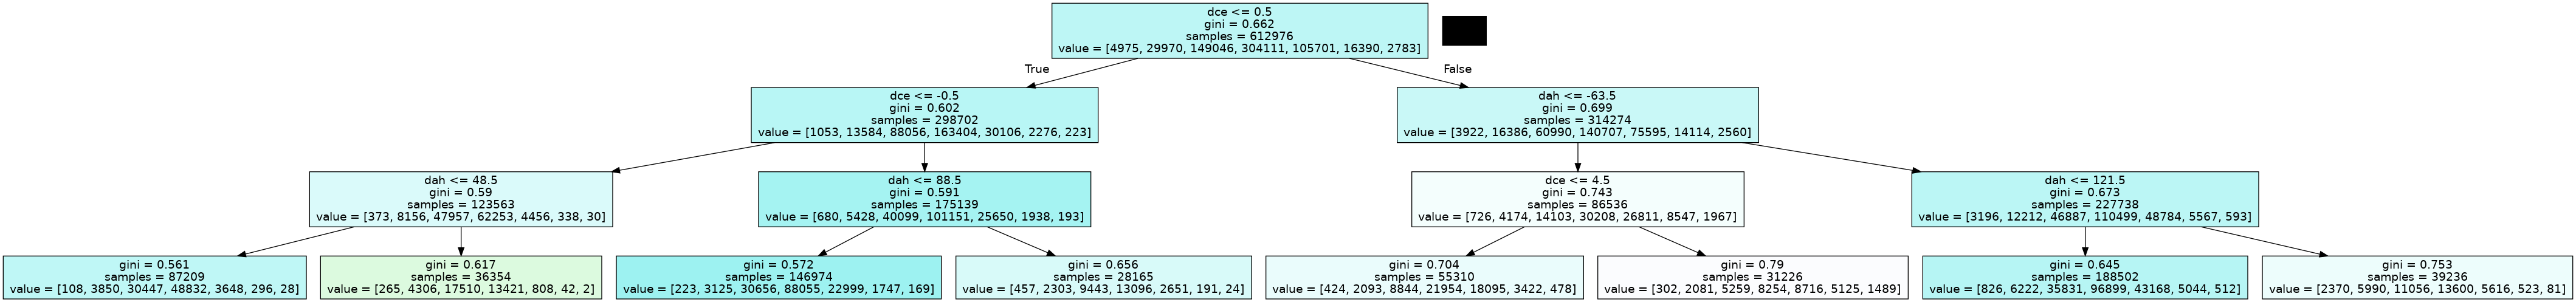

In [29]:
dot_data = tree.export_graphviz(clf, feature_names=X_bin1.columns, filled=True, 
                                out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

## 2. Emsemble Random Forest Classifier 

In [30]:
# n_estimators: the number of times you want to run the decision trees 
# 'n_estimators': [100,250,500]
# 'max_depth':[3,4]
# not sure what "cv" is, but seems to give a warning. needs to be = to number of variables predicting

parameters = {'n_estimators': [30], 'max_depth':[3]} # max depth of 3 without elevation
clf = GridSearchCV(ensemble.RandomForestClassifier(), parameters) #cv=3

clf.fit(X=X_train,y=y_train.values.ravel())
tree_model = clf.best_estimator_

y_pred_train = tree_model.predict(X_train)
y_pred_test = tree_model.predict(X_test)
print('Accuracy on training data is %.2f' % (accuracy_score(y_train, y_pred_train)))
print('Accuracy on test data is %.2f' % (accuracy_score(y_test, y_pred_test)))
print(clf.best_params_)

Accuracy on training data is 0.50
Accuracy on test data is 0.50
{'max_depth': 3, 'n_estimators': 30}


In [31]:
# # clf.feature_importances_ #importance of each variable 
# clf.feature_names_in_

estimator = tree_model.estimators_[3]
estimator


DecisionTreeClassifier(max_depth=3, max_features='sqrt', random_state=403491977)

In [32]:
tree.export_graphviz(estimator, out_file='ensemble_tree.dot', 
                feature_names = X_bin1.columns,
                # class_names = ('no_veg', 'veg'),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'ensemble_tree.dot', '-o', 'ensemble_tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'ensemble_tree.png')

# Elevation Bin Plots

In [145]:
ds

<xarray.Dataset>
Dimensions:        (y: 7483, x: 7297, band: 1)
Coordinates:
  * y              (y) float64 8.125e+05 8.125e+05 8.124e+05 ... 7.9e+05 7.9e+05
  * x              (x) float64 1.487e+06 1.487e+06 ... 1.509e+06 1.509e+06
  * band           (band) int32 1
    spatial_ref    int32 ...
Data variables: (12/24)
    snowdepth      (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    dtm_snowoff    (band, y, x) float32 ...
    dsm_snowoff    (band, y, x) float32 ...
    dtm_snowon     (band, y, x) float32 ...
    dsm_snowon     (band, y, x) float32 ...
    aspect         (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    ...             ...
    dce_reclass    (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    largeclusters  (band, y, x) float32 ...
    smallclusters  (band, y, x) float32 ...
    canopyedges    (band, y, x) float32 ...
    smallgaps      (band, y, x) float32 ...
    largegaps      (band, y, x) float32 ...

In [4]:
## break the data down by elevation bands 
ds_bin1 = ds.where( ds.dem <  1310)                    # less than 1310
ds_bin2 = ds.where((ds.dem >= 1310) & (ds.dem < 1370)) # greater than or = 1310, less than 1370
ds_bin3 = ds.where((ds.dem >= 1370) & (ds.dem < 1480)) # greater than or = 1370, less than 1480
ds_bin4 = ds.where((ds.dem >= 1480) & (ds.dem < 1620)) # greater than or = 1480, less than 1620
ds_bin5 = ds.where( ds.dem >= 1620)                    # greater than or = 1620


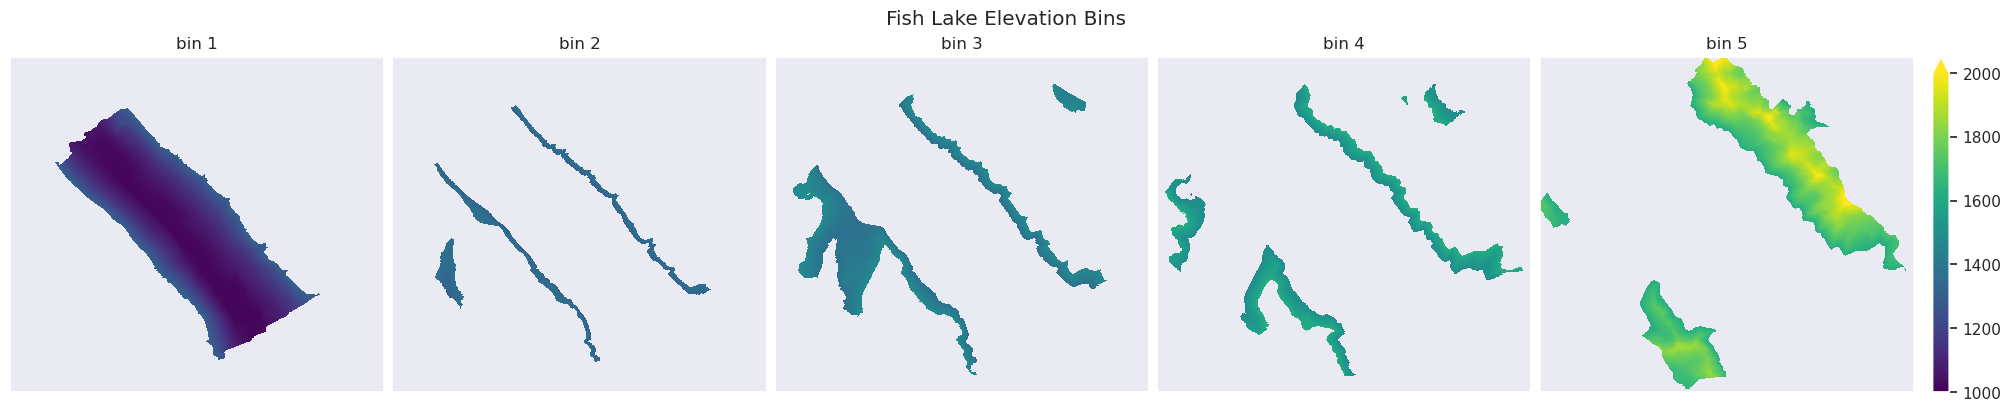

In [4]:
# fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(20,4), constrained_layout = True)

# fig.suptitle('Fish Lake Elevation Bins')

# # 1 row with all 5 elevation bands plotted together on the same cmap
# ds_bin1.dem.plot(ax=axes[0], cmap='viridis', vmin=1000, vmax=2000, add_colorbar=False)
# ds_bin2.dem.plot(ax=axes[1], cmap='viridis', vmin=1000, vmax=2000, add_colorbar=False)
# ds_bin3.dem.plot(ax=axes[2], cmap='viridis', vmin=1000, vmax=2000, add_colorbar=False)
# ds_bin4.dem.plot(ax=axes[3], cmap='viridis', vmin=1000, vmax=2000, add_colorbar=False)
# ds_bin5.dem.plot(ax=axes[4], cmap='viridis', vmin=1000, vmax=2000, add_colorbar=True,  cbar_kwargs={'label':''}) # only a colorbar on the last one, they match 

# # fix all labels and ticks 
# # for ax in axes: # this loop is not working for some reason 
# #     ax.xlabel('')

# # row 1 
# axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])
# axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])
# axes[2].set_xlabel(''); axes[2].set_ylabel(''); axes[2].set_xticks([]); axes[2].set_yticks([])
# axes[3].set_xlabel(''); axes[3].set_ylabel(''); axes[3].set_xticks([]); axes[3].set_yticks([])
# axes[4].set_xlabel(''); axes[4].set_ylabel(''); axes[4].set_xticks([]); axes[4].set_yticks([])

# axes[0].set_title("bin 1")
# axes[1].set_title("bin 2")
# axes[2].set_title("bin 3")
# axes[3].set_title("bin 4")
# axes[4].set_title("bin 5")

# plt.show()

In [5]:
ds_bin1_snowdepth_flat = ds_bin1.snowdepth.values.flatten()
ds_bin1_dce_flat = ds_bin1.dce.values.flatten()
ds_bin1_dce_reclass_flat = ds_bin1.dce_reclass.values.flatten()
ds_bin1_dah_flat = ds_bin1.dah.values.flatten()
ds_bin1_dah_reclass_flat = ds_bin1.dah_reclass.values.flatten()
ds_bin1_dem_flat = ds_bin1.dem.values.flatten()
ds_bin1_tpi_flat = ds_bin1.tpi.values.flatten()

ds_bin2_snowdepth_flat = ds_bin2.snowdepth.values.flatten()
ds_bin2_dce_flat = ds_bin2.dce.values.flatten()
ds_bin2_dce_reclass_flat = ds_bin2.dce_reclass.values.flatten()
ds_bin2_dah_flat = ds_bin2.dah.values.flatten()
ds_bin2_dah_reclass_flat = ds_bin2.dah_reclass.values.flatten()
ds_bin2_dem_flat = ds_bin2.dem.values.flatten()
ds_bin2_tpi_flat = ds_bin2.tpi.values.flatten()

ds_bin3_snowdepth_flat = ds_bin3.snowdepth.values.flatten()
ds_bin3_dce_flat = ds_bin3.dce.values.flatten()
ds_bin3_dce_reclass_flat = ds_bin3.dce_reclass.values.flatten()
ds_bin3_dah_flat = ds_bin3.dah.values.flatten()
ds_bin3_dah_reclass_flat = ds_bin3.dah_reclass.values.flatten()
ds_bin3_dem_flat = ds_bin3.dem.values.flatten()
ds_bin3_tpi_flat = ds_bin3.tpi.values.flatten()

ds_bin4_snowdepth_flat = ds_bin4.snowdepth.values.flatten()
ds_bin4_dce_flat = ds_bin4.dce.values.flatten()
ds_bin4_dce_reclass_flat = ds_bin4.dce_reclass.values.flatten()
ds_bin4_dah_flat = ds_bin4.dah.values.flatten()
ds_bin4_dah_reclass_flat = ds_bin4.dah_reclass.values.flatten()
ds_bin4_dem_flat = ds_bin4.dem.values.flatten()
ds_bin4_tpi_flat = ds_bin4.tpi.values.flatten()

ds_bin5_snowdepth_flat = ds_bin5.snowdepth.values.flatten()
ds_bin5_dce_flat = ds_bin5.dce.values.flatten()
ds_bin5_dce_reclass_flat = ds_bin5.dce_reclass.values.flatten()
ds_bin5_dah_flat = ds_bin5.dah.values.flatten()
ds_bin5_dah_reclass_flat = ds_bin5.dah_reclass.values.flatten()
ds_bin5_dem_flat = ds_bin5.dem.values.flatten()
ds_bin5_tpi_flat = ds_bin5.tpi.values.flatten()

In [6]:
plt.figure(figsize=(12,6))

sns.boxplot(x=ds_bin1_dce_reclass_flat, y=ds_bin1_snowdepth_flat, hue=ds_bin1_dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) 
plt.xlabel('dce (m)')
plt.ylabel('snow depth (m)')
plt.title('Fish Lake: Bin 1')
plt.xticks([0,1,2,3,4], ['Large Clusters','Small Clusters','Edges','Small Gaps', 'Large Gaps'])

plt.show()

: 

: 

## Plots from other script, need to edit them 

IndexError: index 4 is out of bounds for axis 0 with size 4

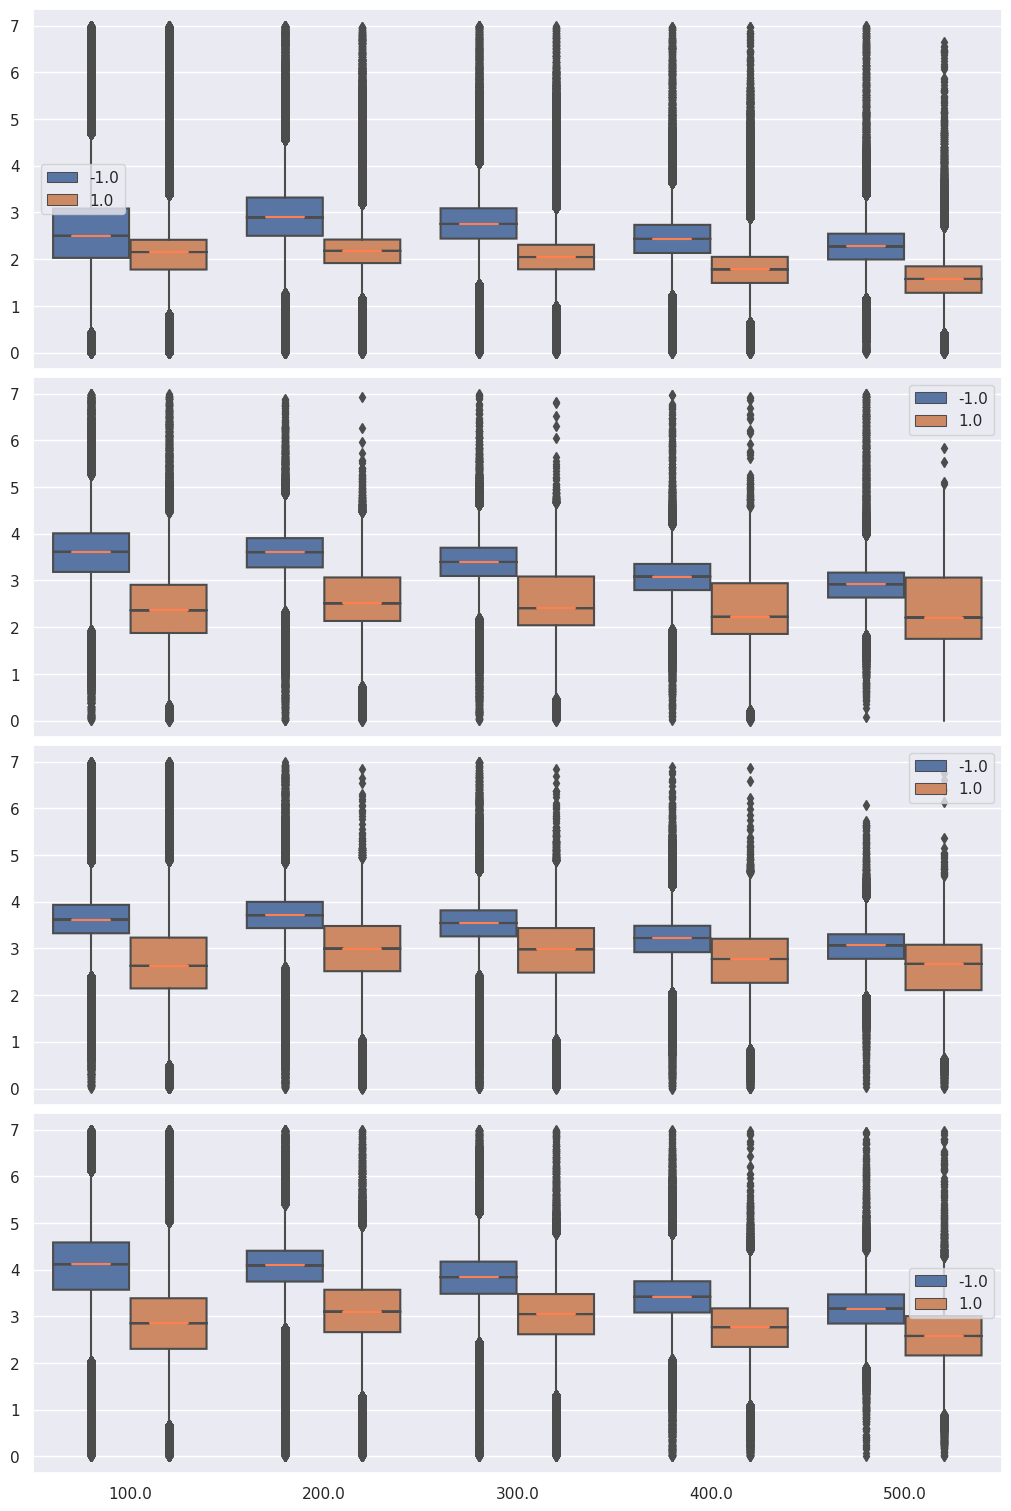

In [6]:
fig, axes = plt.subplots(5, 1, figsize=(10,15), sharex=True, sharey=True, constrained_layout = True) #gridspec_kw={'height_ratios': [2, 2, 2, 2, 2, 2]}

alpha1 = 0.7

binwidth = 5 # elevation into... 5 meter bins? 

sns.boxplot(ax=axes[0], x=ds_bin1_dce_reclass_flat, y=ds_bin1_snowdepth_flat, hue=ds_bin1_dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) 
sns.boxplot(ax=axes[1], x=ds_bin2_dce_reclass_flat, y=ds_bin2_snowdepth_flat, hue=ds_bin2_dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) 
sns.boxplot(ax=axes[2], x=ds_bin3_dce_reclass_flat, y=ds_bin3_snowdepth_flat, hue=ds_bin3_dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) 
sns.boxplot(ax=axes[3], x=ds_bin4_dce_reclass_flat, y=ds_bin4_snowdepth_flat, hue=ds_bin4_dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) 
sns.boxplot(ax=axes[4], x=ds_bin5_dce_reclass_flat, y=ds_bin5_snowdepth_flat, hue=ds_bin5_dah_reclass_flat, notch=True, showcaps=False, medianprops={"color":"coral"}) 

# axes[0].set_ylim([0,12])

# THE BINS
# # ds_bin1 = ds.where( ds.dem <  1310)                    # less than 1310
# ds_bin2 = ds.where((ds.dem >= 1310) & (ds.dem < 1370)) # greater than or = 1310, less than 1370
# ds_bin3 = ds.where((ds.dem >= 1370) & (ds.dem < 1480)) # greater than or = 1370, less than 1480
# ds_bin4 = ds.where((ds.dem >= 1480) & (ds.dem < 1620)) # greater than or = 1480, less than 1620
# ds_bin5 = ds.where( ds.dem >= 1620)                    # greater than or = 1620

axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel('snow depth (m)')
axes[3].set_ylabel("")
axes[4].set_ylabel("")

# axes[4].set_xlabel("")

axes[0].set_title('        dem < 1310m')
axes[1].set_title('1310m < dem < 1370m')
axes[2].set_title('1370m < dem < 1480m')
axes[3].set_title('1480m < dem < 1620m')
axes[4].set_title('        dem > 1620m')

plt.xticks([0,1,2,3,4], ['Large Clusters','Small Clusters','Edges','Small Gaps', 'Large Gaps'])

plt.show()

In [ ]:
plt.figure(figsize=(12,10))

sns.boxplot(x=ds_bin1_dce_reclass_flat, y=ds_bin1_snowdepth_flat, hue=ds_bin1_dah_reclass_flat, notch=True, 
            showcaps=False, medianprops={"color":"coral"}, palette={1: 'peachpuff', -1: 'lightblue'})









sns.boxplot(x=dce_reclass_bydem_2_flat, y=snowdepth_bydem_2_flat, hue=dah_reclass_bydem_2_flat, notch=True, 
            showcaps=False, medianprops={"color":"coral"}, palette={1: 'orange', -1: 'royalblue'})

sns.boxplot(x=dce_reclass_bydem_3_flat, y=snowdepth_bydem_3_flat, hue=dah_reclass_bydem_3_flat, notch=True, 
            showcaps=False, medianprops={"color":"coral"}, palette={1: 'darkorange', -1: 'mediumblue'})

sns.boxplot(x=dce_reclass_bydem_4_flat, y=snowdepth_bydem_4_flat, hue=dah_reclass_bydem_4_flat, notch=True, 
            showcaps=False, medianprops={"color":"coral"}, palette={1: 'chocolate', -1: 'darkblue'})

plt.xlabel(dce_label)
plt.ylabel(snow_label)
plt.title('Fish Lake small domain: increasing darkness of color, increasing elevation')

plt.legend('')
plt.ylim([0,6])

plt.xticks([0,1,2,3,4], ['Large Clusters','Small Clusters','Edges','Small Gaps', 'Large Gaps'])

plt.show()